In [2]:
import os
import tensorflow as tf
import numpy as np

SEED = 1234
tf.random.set_seed(SEED)  


In [3]:
# Run this cell only if you are using Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/training/class_0/12891.jpg  
  inflating: data/training/class_0/12896.jpg  
  inflating: data/training/class_0/12901.jpg  
  inflating: data/training/class_0/12905.jpg  
  inflating: data/training/class_0/12906.jpg  
  inflating: data/training/class_0/12908.jpg  
  inflating: data/training/class_0/12913.jpg  
  inflating: data/training/class_0/12915.jpg  
  inflating: data/training/class_0/12917.jpg  
  inflating: data/training/class_0/12919.jpg  
  inflating: data/training/class_0/12920.jpg  
  inflating: data/training/class_0/12927.jpg  
  inflating: data/training/class_0/12928.jpg  
  inflating: data/training/class_0/12940.jpg  
  inflating: data/training/class_0/12946.jpg  
  inflating: data/training/class_0/12948.jpg  
  inflating: data/training/class_0/12954.jpg  
  inflating: data/training/class_0/12959.jpg  
  inflating: data/training/class_0/12960.jpg  
  inflating: data/training/class_0/12966.jpg  
  inflati

In [5]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255)


In [6]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
# Get current working directory
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'data')

# img

# Batch size
bs = 8

# img shape
img_h = 256
img_w = 256

num_classes=3

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)



Found 5052 images belonging to 3 classes.
Found 562 images belonging to 3 classes.


In [7]:
# Create Dataset objects
# ----------------------
size = (256, 256)
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Shuffle (Already done in generator..)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_gen))

# Normalize images (Already done in generator..)
# def normalize_img(x_, y_):
#     return tf.cast(x_, tf.float32) / 255., y_

# train_dataset = train_dataset.map(normalize_img)

# 1-hot encoding <- for categorical cross entropy (Already done in generator..)
# def to_categorical(x_, y_):
#     return x_, tf.one_hot(y_, depth=10)

# train_dataset = train_dataset.map(to_categorical)

# Divide in batches (Already done in generator..)
# train_dataset = train_dataset.batch(bs)

# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
valid_dataset = valid_dataset.repeat()



InvalidArgumentError: ignored

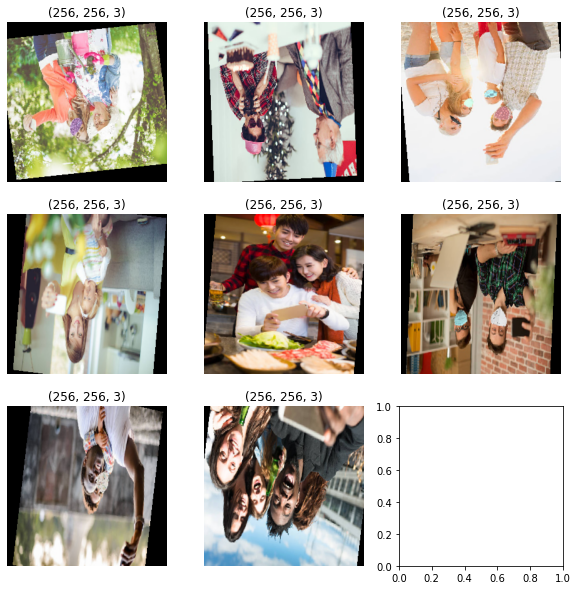

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(image[i].shape)
    plt.axis("off")

In [8]:
IResNet = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

219062272/219055592 [==============================] - 4s 0us/step


In [9]:
# Create Model
# ------------

finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in IResNet.layers[:freeze_until]:
        layer.trainable = False
else:
    IResNet.trainable = False
    
model = tf.keras.Sequential()
model.add(IResNet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

import os
from datetime import datetime



cwd = os.path.join(os.getcwd(),"drive/My Drive/logs")

exps_dir = os.path.join(cwd, 'inceptionResNetV2')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'ResNet'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
    callbacks.append(es_callback)

epochs = 100
model.fit(x=train_dataset, epochs=epochs,steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

Epoch 1/100
632/632 [==============================] - 246s 389ms/step - loss: 0.7625 - accuracy: 0.6584 - val_loss: 8.2440 - val_accuracy: 0.5730
Epoch 2/100
632/632 [==============================] - 243s 385ms/step - loss: 0.4527 - accuracy: 0.8052 - val_loss: 6.0927 - val_accuracy: 0.7349
Epoch 3/100
632/632 [==============================] - 241s 382ms/step - loss: 0.3646 - accuracy: 0.8508 - val_loss: 13.4242 - val_accuracy: 0.6797
Epoch 4/100
632/632 [==============================] - 242s 383ms/step - loss: 0.3173 - accuracy: 0.8759 - val_loss: 7.3317 - val_accuracy: 0.7811
Epoch 5/100
632/632 [==============================] - 242s 383ms/step - loss: 0.2739 - accuracy: 0.8925 - val_loss: 12.1527 - val_accuracy: 0.7794
Epoch 6/100
632/632 [==============================] - 241s 381ms/step - loss: 0.2501 - accuracy: 0.9048 - val_loss: 8.0743 - val_accuracy: 0.7687
Epoch 7/100
632/632 [==============================] - 240s 380ms/step - loss: 0.2387 - accuracy: 0.9032 - val_loss:

In [11]:
model.save('/content/drive/My Drive/IresNet_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/IresNet_model/assets


In [ ]:
model= tf.keras.models.load_model('saved_model')

In [12]:
import pandas as pd
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')


test_dir = os.path.join(dataset_dir, 'test')

images = [f for f in os.listdir(test_dir)]
images = pd.DataFrame(images)
images.rename(columns = {0:'filename'}, inplace = True)
images["class"] = 'test'

test_gen = train_data_gen.flow_from_dataframe(images,
                                               test_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)


test_gen.reset()

predictions = model.predict(test_gen, len(test_gen), verbose=1)

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1

create_csv(results)

Found 450 validated image filenames belonging to 1 classes.
57/57 [==============================] - 10s 183ms/step
